# Exercise 1

Authors:
    - Tuoxing Liu

## 1. Exploring the Data

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


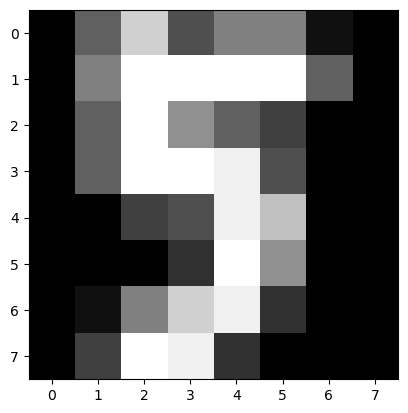

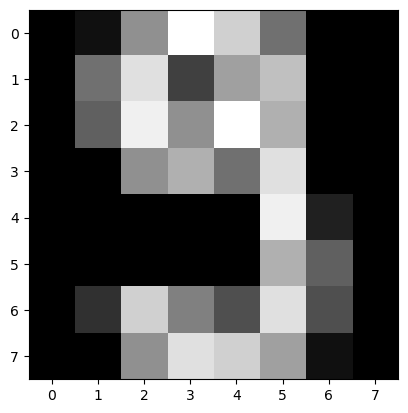

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt

img = digits.images[33]


def print_img(img):
    assert 2 == len(img.shape)
    plt.figure()
    plt.gray()
    plt.imshow(img, interpolation="nearest")  # bicubic, nearest
    plt.show()


print_img(img)


def print_data(data):
    data_temp = data.reshape(8, 8)
    print_img(data_temp)


print_data(digits.data[39])

In [3]:
from sklearn import model_selection
import numpy as np

filter_mask = np.logical_or(target == 3, target == 9)

X_all = data[filter_mask]
y_all = target[filter_mask]

y_all[y_all == 3] = -1
y_all[y_all == 9] = 1
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(
        X_all, y_all, test_size=0.4, random_state=0)

## 2. Hand-crafted classifier

### 2.1 Feature construcition

In [4]:
from sklearn.preprocessing import MinMaxScaler


def features2d(datas):
    features = []
    for data in datas:
        mask = data > 12
        temp = [data[18]+data[26]+data[34]+data[42],
                data[11]+data[19]-data[35]-data[43]]
        features.append(temp)

    # normalize
    features_norm = MinMaxScaler().fit_transform(features)

    return features_norm

X_train_2d = features2d(X_train)
X_test_2d = features2d(X_test)

### 2.2 Scatterplot

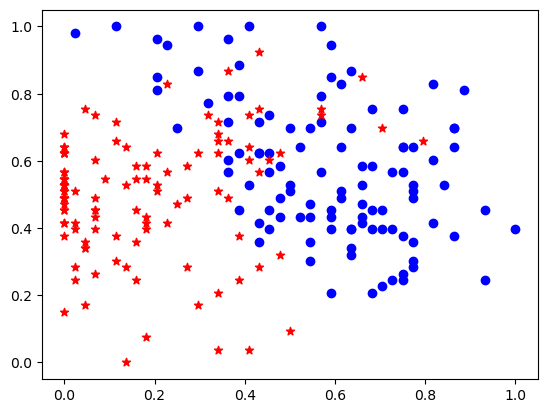

In [5]:
def draw_feature(features, label):
    for feature, y in zip(features, label):
        if y == 3 or y == -1:
            marker = "*"
            color = "red"
        elif y == 9 or y == 1:
            marker = "o"
            color = "blue"
        plt.scatter(feature[0], feature[1], marker=marker, color=color)
        # plt.show()


draw_feature(X_train_2d, y_train)

### 2.3 Decision rule


In [6]:
def nearest_mean(training_features, training_labels, test_festures):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    f_negetive = t_features[t_labels == -1].mean(axis=0)
    f_positive = t_features[t_labels == 1].mean(axis=0)

    labels = []
    for f in test_festures:
        if abs(f-f_negetive).sum() > abs(f-f_positive).sum():
            labels.append(1)
        else:
            labels.append(-1)

    return np.array(labels)


def print_errors_nearest(X_train, y_train, X_test, y_test):
    train_labels = nearest_mean(X_train, y_train, X_train)
    test_labels = nearest_mean(X_train, y_train, X_test)

    training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
    test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
    print(f"training error: {training_error}")
    print(f"test error: {test_error}")


print_errors_nearest(X_train_2d, y_train, X_test_2d, y_test)

training error: 0.1336405529953917
test error: 0.11643835616438356


cross validation for nearest mean (64d)

In [7]:
from sklearn.model_selection import KFold

def cross_validation_nearest(X,y,n_splits=10):
    # create a 5-fold cross-validation iterator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)


    test_errors=[]
    # loop over the folds and train/test the model on each fold
    for train_index, test_index in kf.split(X):
        # get the training and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        

        # evaluate the model on the test data for this fold
        test_labels = nearest_mean(X_train, y_train, X_test)
        test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
        test_errors.append(test_error)

    total_error = np.array(test_errors).mean()
    print(f"cross validation error: {total_error}")
    return total_error


cross_validation_nearest(X_all,y_all,n_splits=10)

cross validation error: 0.038513513513513516


0.038513513513513516

cross validation for nearest mean (2d)

In [8]:
cross_validation_nearest(features2d(X_all),y_all,n_splits=10)

cross validation error: 0.1322072072072072


0.1322072072072072

### 2.4 Visualize the decision regions

training error: 0.1336405529953917
test error: 0.11643835616438356


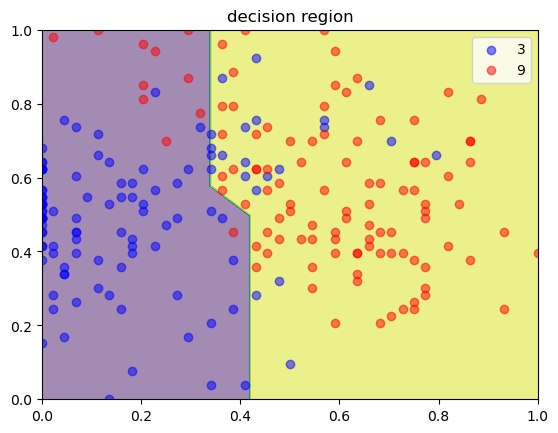

In [9]:
def visualize_nearest(X_train_2d,y_train):
    xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
    grid_features = np.c_[xx.ravel(), yy.ravel()]
    
    grid_predicted_labels  = nearest_mean(X_train_2d, y_train, grid_features).reshape(xx.shape)
    plt.contourf(xx, yy, np.array(grid_predicted_labels), cmap='viridis', alpha=0.5)

    plt.scatter(X_train_2d[y_train == -1,0],X_train_2d[y_train == -1,1], label='3', c='b', alpha=0.5)
    plt.scatter(X_train_2d[y_train == 1,0],X_train_2d[y_train == 1,1], label='9', c='r', alpha=0.5)
    plt.legend()
    plt.title("decision region")


visualize_nearest(X_train_2d,y_train)
print_errors_nearest(X_train_2d,y_train,X_test_2d,y_test)

## 3. LDA

### 3.1 Implement LDA training

In [10]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


def fit_lda(X, y, reg=1e-6):
    n_samples, n_features = X.shape
    classes = np.unique(y)
    n_classes = len(classes)

    # Check if any classes have zero samples
    empty_classes = []
    for c in classes:
        if np.sum(y == c) == 0:
            empty_classes.append(c)
    
    # Remove empty classes from the dataset
    X = np.delete(X, np.where(np.isin(y, empty_classes)), axis=0)
    y = np.delete(y, np.where(np.isin(y, empty_classes)))

    mu = np.zeros((n_features, n_classes))
    covmat = np.zeros((n_features, n_features))
    p = np.zeros(n_classes)

    for i, c in enumerate(classes):
        Xc = X[y == c, :]
        n_samples_c = Xc.shape[0]
        mu[:, i] = np.mean(Xc, axis=0)
        covmat += (1 / n_samples_c) * np.dot((Xc - mu[:, i]).T, (Xc - mu[:, i]))
        p[i] = n_samples_c / X.shape[0]

    covmat += reg * np.identity(n_features)
   
    return mu, covmat, p

In [11]:
# Fit LDA model
mu, covmat, p = fit_lda(X_train_2d, y_train)

# Print the results
print('mu:', mu)
print('covmat:', covmat)
print('p:', p)

mu: [[0.17977068 0.58211835]
 [0.49736529 0.57707369]]
covmat: [[ 0.07081433 -0.0131881 ]
 [-0.0131881   0.07666894]]
p: [0.51152074 0.48847926]


### 3.2 Implement LDA prediction



In [12]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split



def predict_lda(mu, covmat, p, test_features):
    n_test = test_features.shape[0]
    predicted_labels = np.zeros(n_test, dtype=np.int8)

    for i in range(n_test):
        x = test_features[i, :]
        g_3 = -0.5 * (x.reshape(-1, 1) - mu[:, 0].reshape(-1, 1)).T @ np.linalg.inv(covmat) @ (x.reshape(-1, 1) - mu[:, 0].reshape(-1, 1)) + np.log(p[0])
        g_9 = -0.5 * (x.reshape(-1, 1) - mu[:, 1].reshape(-1, 1)).T @ np.linalg.inv(covmat) @ (x.reshape(-1, 1) - mu[:, 1].reshape(-1, 1)) + np.log(p[1])
        predicted_labels[i] = -1 if g_3 > g_9 else 1

    return predicted_labels


# Fit LDA model
mu, covmat, p = fit_lda(X_train_2d, y_train)

# Make predictions on test set
test_pred = predict_lda(mu, covmat, p, X_test_2d)
print(test_pred)


[-1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1
 -1 -1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1
 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1
  1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1
  1  1 -1 -1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1 -1
  1  1]


### 3.3 Visualization

training error: 0.1336405529953917
test error: 0.10273972602739725


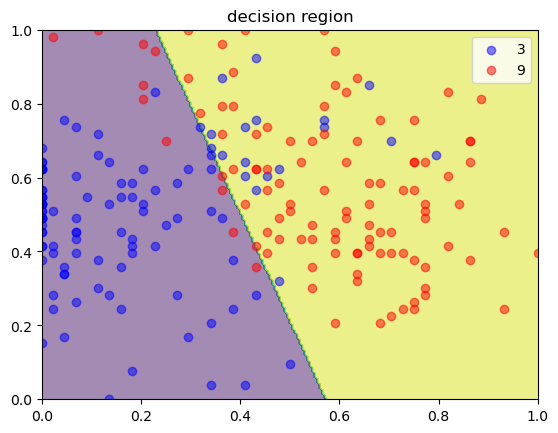

In [13]:
def visualize_lda(mu, covmat, p,X_train_2d,y_train):
    xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
    grid_features = np.c_[xx.ravel(), yy.ravel()]

    grid_predicted_labels  = predict_lda(mu, covmat, p, grid_features).reshape(xx.shape)
    plt.contourf(xx, yy, np.array(grid_predicted_labels), cmap='viridis', alpha=0.5)

    plt.scatter(X_train_2d[y_train == -1,0],X_train_2d[y_train == -1,1], label='3', c='b', alpha=0.5)
    plt.scatter(X_train_2d[y_train == 1,0],X_train_2d[y_train == 1,1], label='9', c='r', alpha=0.5)
    plt.legend()
    plt.title("decision region")

def print_errors_lda(mu, covmat, p, X_train,y_train,X_test,y_test):
    train_labels = predict_lda(mu, covmat, p,X_train)
    test_labels = predict_lda(mu, covmat, p,X_test)

    training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
    test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
    print(f"training error: {training_error}")
    print(f"test error: {test_error}")


mu, covmat, p = fit_lda(X_train_2d,y_train)
visualize_lda(mu, covmat, p,X_train_2d,y_train)
print_errors_lda(mu, covmat, p, X_train_2d,y_train,X_test_2d,y_test)

### 3.4 Quantitative performance evaluation

64d LDA

In [14]:
mu, covmat, p = fit_lda(X_train, y_train)
test_pred = predict_lda(mu, covmat, p, X_test)
print_errors_lda(mu, covmat, p, X_train,y_train,X_test,y_test)

training error: 0.004608294930875576
test error: 0.0136986301369863


cross validation for custom LDA

In [15]:
from sklearn.model_selection import KFold

def cross_validation_lda(X,y,n_splits=10):
    # create a 5-fold cross-validation iterator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)


    test_errors=[]
    # loop over the folds and train/test the model on each fold
    for train_index, test_index in kf.split(X):
        # get the training and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # train the model on the training data for this fold
        mu, covmat, p =fit_lda(X_train,y_train)

        # evaluate the model on the test data for this fold
        test_labels = predict_lda(mu, covmat, p, X_test)
        test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
        test_errors.append(test_error)

    total_error = np.array(test_errors).mean()
    print(f"cross validation error: {total_error}")
    return total_error


cross validation for LDA (64d)

In [16]:
cross_validation_lda(X_all,y_all,n_splits=10)

cross validation error: 0.011036036036036036


0.011036036036036036

cross validation for LDA (2d)

In [17]:
cross_validation_lda(features2d(X_all),y_all,n_splits=10)

cross validation error: 0.12364864864864866


0.12364864864864866

cross validation for offical LDA

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_sklearn = LinearDiscriminantAnalysis()
scores_sklearn = cross_val_score(lda_sklearn, X_all, y_all, cv=10)

print(f"cross validation error (scikit-learn): {1-np.mean(scores_sklearn)}")

cross validation error (scikit-learn): 0.02207207207207218


Our custom version is slightly better thant the offical package.

## 4. SVM

In [19]:
def ReLU(x):
    return np.maximum(0, x)


def loss_svm(beta, b, weight, X, y):
    print((X @ beta + b).shape)
    print((y*(X @ beta + b)).shape)
    return 0.5*beta.T@beta + weight/len(y) * np.sum(ReLU(1-y*(X @ beta + b)), axis=0)


def loss_partial_beta(beta, b, weight, X, y):
    wrong_filter = y*(X@beta+b) < 1
    X_wrong = X[wrong_filter]
    y_wrong = y[wrong_filter].reshape(-1, 1)
    return beta + weight/len(y) * np.sum(-y_wrong*X_wrong, axis=0)


def loss_partial_b(beta, b, weight, X, y):
    wrong_filter = y*(X@beta+b) < 1
    y_wrong = y[wrong_filter].reshape(-1, 1)

    return weight/len(y) * np.sum(-y_wrong)


def fit_svm(training_features, training_labels, T=100, weight=0.2, learning_rate=0.8):
    t_features = np.array(training_features)
    t_labels = np.array(training_labels)

    beta = np.random.normal(0, 1, t_features.shape[1])
    b = 0

    training_errors = []
    for i in range(T):
        if i % 5 == 0:
            learning_rate *= 0.5
        beta = beta - learning_rate * \
            loss_partial_beta(beta, b, weight, t_features, t_labels)
        b = b - learning_rate * \
            loss_partial_b(beta, b, weight, t_features, t_labels)

        train_labels = predict_svm(beta, b, t_features)
        training_error = abs(train_labels - t_labels).sum()/(2*len(t_labels))
        training_errors.append(training_error)

    return beta, b, training_errors


def predict_svm(beta, b, test_features):
    return np.sign(test_features @ beta + b)

def print_errors_svm(beta,b, X_train,y_train,X_test,y_test):
    train_labels = predict_svm(beta,b,X_train)
    test_labels = predict_svm(beta,b,X_test)

    training_error = abs(train_labels - y_train).sum()/(2*len(y_train))
    test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
    print(f"training error: {training_error}")
    print(f"test error: {test_error}")

### SVM on 2d features

[0.1142095 0.0237768] -0.05529948643275669
training error: 0.1382488479262673
test error: 0.11643835616438356


Text(0, 0.5, 'learning error')

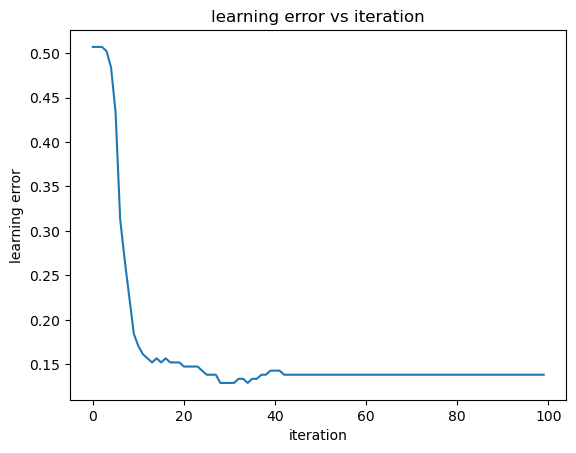

In [20]:
beta,b,errors = fit_svm(features2d(X_train),y_train,weight=0.6)
print(beta,b)

print_errors_svm(beta,b, X_train_2d,y_train,X_test_2d,y_test)

plt.plot(range(len(errors)),errors)
plt.title("learning error vs iteration")
plt.xlabel("iteration")
plt.ylabel("learning error")

### SVM on 64d features

training error: 0.009216589861751152
test error: 0.0136986301369863


Text(0, 0.5, 'learning error')

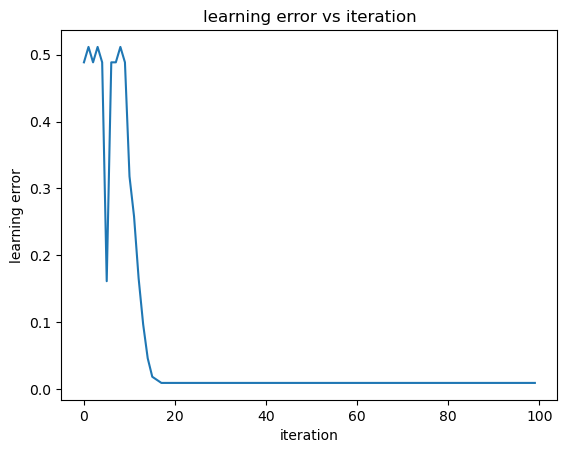

In [21]:
beta,b,errors = fit_svm(X_train,y_train,weight=0.6)
# print(beta,b)



print_errors_svm(beta,b, X_train,y_train,X_test,y_test)
plt.plot(range(len(errors)),errors)
plt.title("learning error vs iteration")
plt.xlabel("iteration")
plt.ylabel("learning error")



### Cross validation for weight(lambda)

In [22]:
from sklearn.model_selection import KFold

def cross_validation_svm(X,y,weights,n_splits=10):
    # create a 5-fold cross-validation iterator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    errors=[]
    for weight in weights:
        test_errors=[]
        # loop over the folds and train/test the model on each fold
        for train_index, test_index in kf.split(X):
            # get the training and test data for this fold
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # train the model on the training data for this fold
            beta,b,_=fit_svm(X_train,y_train,weight = weight)

            # evaluate the model on the test data for this fold
            test_labels = predict_svm(beta,b,X_test)
            test_error = abs(test_labels - y_test).sum()/(2*len(y_test))
            test_errors.append(test_error)

        error=np.array(test_errors).mean()
        errors.append(error)
        print(f"weight:{weight}, error:{error}")

    best_weight=weights[np.argmin(errors)]
    best_error = errors[np.argmin(errors)]
    print(f"best weight:{best_weight}, best training error:{best_error}")
    return best_weight,best_error

cross_validation_svm(X_train,y_train,np.linspace(0,2,100))

weight:0.0, error:0.44393939393939397
weight:0.020202020202020204, error:0.02748917748917749
weight:0.04040404040404041, error:0.013852813852813853
weight:0.06060606060606061, error:0.018398268398268396
weight:0.08080808080808081, error:0.009307359307359308
weight:0.10101010101010102, error:0.013852813852813853
weight:0.12121212121212122, error:0.009307359307359308
weight:0.14141414141414144, error:0.022943722943722943
weight:0.16161616161616163, error:0.009307359307359308
weight:0.18181818181818182, error:0.022943722943722943
weight:0.20202020202020204, error:0.022943722943722943
weight:0.22222222222222224, error:0.013852813852813853
weight:0.24242424242424243, error:0.018398268398268396
weight:0.26262626262626265, error:0.013852813852813853
weight:0.2828282828282829, error:0.013852813852813853
weight:0.30303030303030304, error:0.022943722943722943
weight:0.32323232323232326, error:0.018398268398268396
weight:0.3434343434343435, error:0.013852813852813853
weight:0.36363636363636365, e

(0.08080808080808081, 0.009307359307359308)

In [23]:
cross_validation_svm(features2d(X_train),y_train,np.linspace(0,2,100))

weight:0.0, error:0.535064935064935
weight:0.020202020202020204, error:0.5311688311688311
weight:0.04040404040404041, error:0.4913419913419913
weight:0.06060606060606061, error:0.4696969696969697
weight:0.08080808080808081, error:0.44588744588744583
weight:0.10101010101010102, error:0.3541125541125541
weight:0.12121212121212122, error:0.3677489177489177
weight:0.14141414141414144, error:0.4283549783549784
weight:0.16161616161616163, error:0.34458874458874456
weight:0.18181818181818182, error:0.4041125541125541
weight:0.20202020202020204, error:0.3911255411255411
weight:0.22222222222222224, error:0.39999999999999997
weight:0.24242424242424243, error:0.4270562770562771
weight:0.26262626262626265, error:0.3772727272727273
weight:0.2828282828282829, error:0.3586580086580086
weight:0.30303030303030304, error:0.39069264069264065
weight:0.32323232323232326, error:0.3632034632034632
weight:0.3434343434343435, error:0.3766233766233766
weight:0.36363636363636365, error:0.3952380952380952
weight:

(1.0303030303030305, 0.34307359307359303)

For 64 dim features: 
- best weight: 0.06
- best training error:0.009

For 2 dim features: 
- best weight: 0.58
- best training error: 0.33

cross validation for svm (64d)

In [24]:
cross_validation_svm(X_all,y_all,[0.06])

weight:0.06, error:0.008258258258258258
best weight:0.06, best training error:0.008258258258258258


(0.06, 0.008258258258258258)

cross validaion for svm (2d)

In [25]:
cross_validation_svm(features2d(X_all),y_all,[0.6])

weight:0.6, error:0.3721471471471471
best weight:0.6, best training error:0.3721471471471471


(0.6, 0.3721471471471471)

### Visualize the decision boundary

training error: 0.14746543778801843
test error: 0.10273972602739725


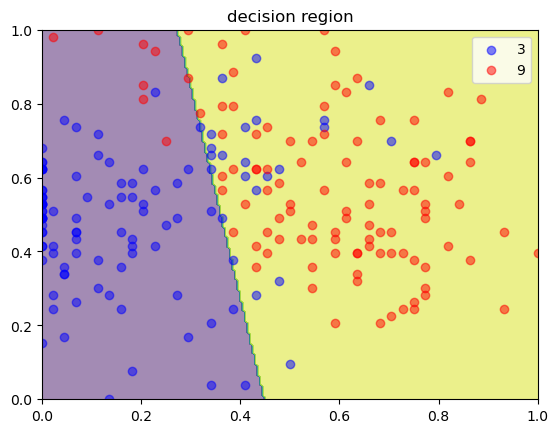

In [26]:
def visualize_svm(beta,b,X_train_2d,y_train):
    xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
    grid_features = np.c_[xx.ravel(), yy.ravel()]

    grid_predicted_labels = predict_svm(beta,b,grid_features).reshape(xx.shape)
    plt.contourf(xx, yy, np.array(grid_predicted_labels), cmap='viridis', alpha=0.5)

    plt.scatter(X_train_2d[y_train == -1,0],X_train_2d[y_train == -1,1], label='3', c='b', alpha=0.5)
    plt.scatter(X_train_2d[y_train == 1,0],X_train_2d[y_train == 1,1], label='9', c='r', alpha=0.5)
    plt.legend()
    plt.title("decision region")


beta,b,errors = fit_svm(features2d(X_train),y_train,weight=0.6)
visualize_svm(beta,b,X_train_2d,y_train)
print_errors_svm(beta,b, X_train_2d,y_train,X_test_2d,y_test)

### Compare with sklearn.svm

training error: 0.12442396313364056
test error: 0.1095890410958904


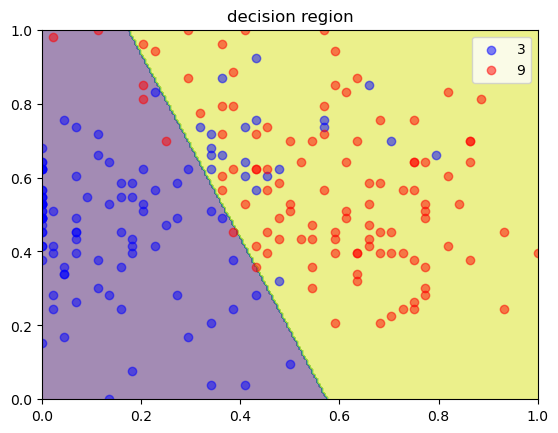

In [27]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_2d, y_train)
beta = svm.coef_.reshape(-1)
b = svm.intercept_

visualize_svm(beta,b,X_train_2d,y_train)
print_errors_svm(beta,b, X_train_2d,y_train,X_test_2d,y_test)

The official package has similar performance with our custom one and they have different decision plane.


### How does the prediction quality change relative to LDA and the nearest mean classier

cross validation: (64d)
- nearest mean: 0.0385
- LDA: 0.0110
- SVM: 0.0138

cross validation: (2d)
- nearest mean: 0.1322
- LDA: 0.1236
- SVM: 0.3988

In 64d, the performance of LDA and SVM is similar, and they are significantly better than nearest mean.
In 2d, the performance of SVM and nearest mean is similar, and they are significantly better than SVM.